<a href="https://colab.research.google.com/github/josvalen/practicetemp/blob/main/Zoobot_Finetune_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import logging

logging.basicConfig(level=logging.INFO)

This notebook demonstrates finetuning Zoobot.

Finetuning means adapting a model pretrained on a large amount of data (here, many Galaxy Zoo answers) to solve a new problem using a small amount of new data.

We follow these steps:
- Install Zoobot (PyTorch version)
- Downloads a pretrained checkpoint
- Download the data to finetune on, starting from that checkpoint and the data to finetune on (ring images and ring label catalog)
- Configure and run the finetuning

For standalone script examples, see zoobot/pytorch/examples/finetuning



---



*Retraining will be quite slow unless you use a GPU. Use the top
toolbar: Runtime- > Change Runtime -> GPU*

---

## Install Zoobot

In [2]:
!git clone https://github.com/mwalmsley/zoobot.git # places the cloned repo into zoobot_dir

# there's an identical notebook I use for testing the pre-release versions of zoobot and galaxy-datasets here, if useful
# https://colab.research.google.com/drive/1A_-M3Sz5maQmyfW2A7rEu-g_Zi0RMGz5?usp=sharing

Cloning into 'zoobot'...
remote: Enumerating objects: 8328, done.
remote: Counting objects: 100% (2316/2316), done.
remote: Compressing objects: 100% (763/763), done.
remote: Total 8328 (delta 1600), reused 2252 (delta 1543), pack-reused 6012
Receiving objects: 100% (8328/8328), 334.16 MiB | 15.77 MiB/s, done.
Resolving deltas: 100% (5192/5192), done.


In [3]:
!pip install -e /content/zoobot[pytorch_colab]

Obtaining file:///content/zoobot
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 952.4/952.4 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.8/722.8 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.4/275.4 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.5/732.5 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━



If you will get the error below later:
> AttributeError: module 'pkg_resources._vendor.packaging' has no attribute 'requirements'

then restart the runtime and run it again - press the button just above.

In [4]:
# google colab needs this hack to make git-cloned packaged importable
# it's not needed locally
import os
import sys
zoobot_dir = '/content/zoobot'
os.chdir(zoobot_dir)
sys.path.append(zoobot_dir)
!git pull  # just to make sure we're up to date

Already up to date.


Now we're set up and can start using Zoobot.

## Download Pretrained Checkpoint

In [5]:


# make a directory to place the checkpoint
# this could be anywhere, but Zoobot has this folder already
checkpoint_dir = os.path.join(zoobot_dir, 'data/pretrained_models/pytorch')  # Can place your checkpoint anywhere,

# if not os.path.isdir(checkpoint_dir):
#   os.makedirs(checkpoint_dir)

Download the pretrained model checkpoint from Dropbox.

The pretrained models are described and linked from the [Data Notes](https://zoobot.readthedocs.io/en/latest/data_notes.html) docs.

Outside Colab, you can just download them with a browser.
On Colab, we don't have a file browser, so we have will download them with this one-liner.

In [6]:
!wget --no-check-certificate 'https://dl.dropboxusercontent.com/s/7ixwo59imjfz4ay/effnetb0_greyscale_224px.ckpt?dl=0' -O $checkpoint_dir/checkpoint.ckpt

--2023-07-27 20:56:21--  https://dl.dropboxusercontent.com/s/7ixwo59imjfz4ay/effnetb0_greyscale_224px.ckpt?dl=0
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.3.15, 2620:100:6018:15::a27d:30f
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.3.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17384753 (17M) [application/octet-stream]
Saving to: ‘/content/zoobot/data/pretrained_models/pytorch/checkpoint.ckpt’

/content/zoobot/dat 100%[===================>]  16.58M  5.75MB/s    in 2.9s    

2023-07-27 20:56:27 (5.75 MB/s) - ‘/content/zoobot/data/pretrained_models/pytorch/checkpoint.ckpt’ saved [17384753/17384753]



## Download Catalogs of Images and Labels

Each catalog should be a dataframe with columns of "id_str", "file_loc", and any labels.

Here I'm using galaxy-datasets to download some premade data - check it out for examples.

In [7]:
# galaxy-datasets is a dependency of Zoobot.
# It has code handling downloading and loading data.
from galaxy_datasets import gz_candels

In [8]:
data_dir = os.path.join(zoobot_dir, 'data/gz_candels')

In [10]:
train_catalog, label_cols = gz_candels(root=data_dir, download=True, train=True)
test_catalog, _ = gz_candels(root=data_dir, download=True, train=False)

In [11]:
train_catalog.head()

,smooth-or-featured-candels_smooth,smooth-or-featured-candels_features,smooth-or-featured-candels_artifact,how-rounded-candels_completely,how-rounded-candels_in-between,how-rounded-candels_cigar-shaped,clumpy-appearance-candels_yes,clumpy-appearance-candels_no,clump-count-candels_1,clump-count-candels_2,clump-count-candels_3,clump-count-candels_4,clump-count-candels_5-plus,clump-count-candels_cant-tell,disk-edge-on-candels_yes,disk-edge-on-candels_no,edge-on-bulge-candels_yes,edge-on-bulge-candels_no,bar-candels_yes,bar-candels_no,has-spiral-arms-candels_yes,has-spiral-arms-candels_no,spiral-winding-candels_tight,spiral-winding-candels_medium,spiral-winding-candels_loose,spiral-arm-count-candels_1,spiral-arm-count-candels_2,spiral-arm-count-candels_3,spiral-arm-count-candels_4,spiral-arm-count-candels_5-plus,spiral-arm-count-candels_cant-tell,bulge-size-candels_none,bulge-size-candels_obvious,bulge-size-candels_dominant,merging-candels_merger,merging-candels_tidal-debris,merging-candels_both,merging-candels_neither,filename,file_loc
0,7.0,0.0,17.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,UDS_14439.jpg,/content/zoobot/data/gz_candels/images/UDS_144...
1,14.0,4.0,16.0,5.0,9.0,0.0,4.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,14.0,COS_89.jpg,/content/zoobot/data/gz_candels/images/COS_89.jpg
2,5.0,5.0,8.0,2.0,3.0,0.0,3.0,2.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,10.0,GDS_14317.jpg,/content/zoobot/data/gz_candels/images/GDS_143...
3,17.0,7.0,12.0,4.0,13.0,0.0,2.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,1.0,4.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,1.0,2.0,2.0,2.0,18.0,UDS_9017.jpg,/content/zoobot/data/gz_candels/images/UDS_901...
4,8.0,2.0,12.0,4.0,3.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,COS_7477.jpg,/content/zoobot/data/gz_candels/images/COS_747...


Wondering about "label_cols"?

This is a list of catalog columns which should be used as labels

Here,`label_cols = ['ring']`



In [12]:
label_cols

['smooth-or-featured-candels_smooth',
 'smooth-or-featured-candels_features',
 'smooth-or-featured-candels_artifact',
 'how-rounded-candels_completely',
 'how-rounded-candels_in-between',
 'how-rounded-candels_cigar-shaped',
 'clumpy-appearance-candels_yes',
 'clumpy-appearance-candels_no',
 'clump-count-candels_1',
 'clump-count-candels_2',
 'clump-count-candels_3',
 'clump-count-candels_4',
 'clump-count-candels_5-plus',
 'clump-count-candels_cant-tell',
 'disk-edge-on-candels_yes',
 'disk-edge-on-candels_no',
 'edge-on-bulge-candels_yes',
 'edge-on-bulge-candels_no',
 'bar-candels_yes',
 'bar-candels_no',
 'has-spiral-arms-candels_yes',
 'has-spiral-arms-candels_no',
 'spiral-winding-candels_tight',
 'spiral-winding-candels_medium',
 'spiral-winding-candels_loose',
 'spiral-arm-count-candels_1',
 'spiral-arm-count-candels_2',
 'spiral-arm-count-candels_3',
 'spiral-arm-count-candels_4',
 'spiral-arm-count-candels_5-plus',
 'spiral-arm-count-candels_cant-tell',
 'bulge-size-candels_n

For binary classification, the label column should have binary (0 or 1) labels for your classes.

To support more complicated labels, Zoobot expects a list of columns. A list with one element works fine.


## Configure Finetuning

In [41]:
import pandas as pd

from zoobot.pytorch.training import finetune
from galaxy_datasets.pytorch.galaxy_datamodule import GalaxyDataModule

In [40]:
# TODO you can update these paths to suit own data
checkpoint_loc = os.path.join(zoobot_dir, 'data/pretrained_models/pytorch/checkpoint.ckpt')  # downloaded above
save_dir = os.path.join(zoobot_dir, 'results/pytorch/finetune/finetune_binary_classification')

In [39]:
label_col = 'merging-candels_merger'  # name of column in catalog with binary (0 or 1) labels for your classes
label_cols = [label_col]  # To support more complicated labels, Zoobot expects a list of columns. A list with one element works fine.

In [38]:
datamodule = GalaxyDataModule(
  label_cols=label_cols,
  catalog=train_catalog,
  batch_size=32,
  resize_after_crop=224,  # the size of the images input to the model
  num_workers=2  # sets the parallelism for loading data. 2 works well on colab.
)

## Check Images Load

Optional - check that all images load correctly.

Worth checking once, and especially if you get "InvalidArgumentError" when running the model below.

In [17]:
assert all([os.path.isfile(loc) for loc in train_catalog['file_loc']])

# Now the Actual Finetuning

In [42]:
from zoobot.shared.schemas import gz_candels_ortho_schema
schema = gz_candels_ortho_schema
model = finetune.FinetuneableZoobotTree(checkpoint_loc=checkpoint_loc, schema=schema)
    # retrain to find rings
trainer = finetune.get_trainer(save_dir, accelerator='cpu', max_epochs=1)
trainer.fit(model, datamodule)

RuntimeError: ignored

In [27]:
trainer = finetune.get_trainer(save_dir)
trainer.fit(model, datamodule)
# should reach about 80% accuracy, loss of about 0.4

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


RuntimeError: ignored

In [23]:
# now we can load the best checkpoint and make predictions
best_checkpoint = trainer.checkpoint_callback.best_model_path
finetuned_model = finetune.FinetuneableZoobotClassifier.load_from_checkpoint(best_checkpoint)

IsADirectoryError: ignored

In [24]:
from zoobot.pytorch.predictions import predict_on_catalog

predict_on_catalog.predict(
  test_catalog,
  finetuned_model,
  n_samples=1,
  label_cols=label_cols,
  save_loc=os.path.join(save_dir, 'finetuned_predictions.csv'),
  trainer_kwargs={'accelerator': 'gpu'},
  datamodule_kwargs={'num_workers': 2}
)

NameError: ignored

Let's quickly check if they're any good:

In [ ]:
predictions = pd.read_csv(os.path.join(save_dir, 'finetuned_predictions.csv'))
predictions.head()

,id_str,ring_pred
0,453526_3245,0.834342
1,127202_5277,0.612222
2,469597_327,0.234862
3,433105_1762,0.083331
4,52497_3109,0.733985


In [ ]:

predictions = pd.merge(predictions, test_catalog[['id_str', 'file_loc', 'ring']])
predictions.head()

,id_str,ring_pred,file_loc,ring
0,453526_3245,0.834342,/content/zoobot/data/demo_rings/images/453526/...,True
1,127202_5277,0.612222,/content/zoobot/data/demo_rings/images/127202/...,True
2,469597_327,0.234862,/content/zoobot/data/demo_rings/images/469597/...,False
3,433105_1762,0.083331,/content/zoobot/data/demo_rings/images/433105/...,False
4,52497_3109,0.733985,/content/zoobot/data/demo_rings/images/52497/5...,True


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def show_rings(df):
  # little utility function to visualise galaxies and our ring labels/predictions

  fig, axes = plt.subplots(ncols=5, figsize=(16, 3))
  for n in range(5):
    galaxy = df.iloc[n]

    im = Image.open(galaxy['file_loc'])
    axes[n].imshow(im)

    correct = np.around(galaxy['ring_pred']) == galaxy['ring']
    if correct:
      color = 'g'
    else:
      color = 'r'
    axes[n].text(20, 50, 'Pred: {:.2f}'.format(galaxy['ring_pred']), color=color)
    axes[n].text(20, 90, 'Label: {}'.format(galaxy['ring']), color=color)

    axes[n].axis('off')

58      426886_971
103    431614_3909
63     333402_4852
47      208040_773
45     228384_1060
          ...     
198    405401_3343
138    333247_6110
159    281661_4750
15     329088_5754
175    452368_2911
Name: id_str, Length: 200, dtype: object


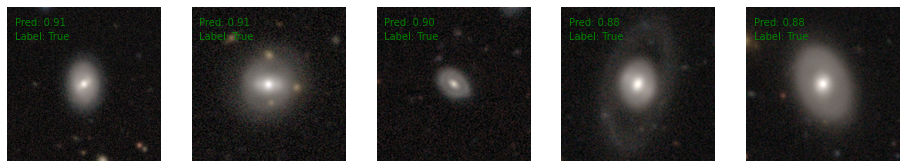

In [ ]:
top_5_predictions = predictions.sort_values('ring_pred', ascending=False)
show_rings(top_5_predictions)
print(top_5_predictions['id_str'])

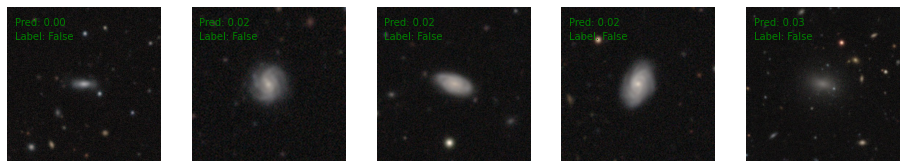

In [ ]:
bottom_5_predictions = predictions.sort_values('ring_pred', ascending=True)
show_rings(bottom_5_predictions)

56     311489_3363
109    398373_2308
42      333141_441
148    368315_3040
6        458851_85
Name: id_str, dtype: object


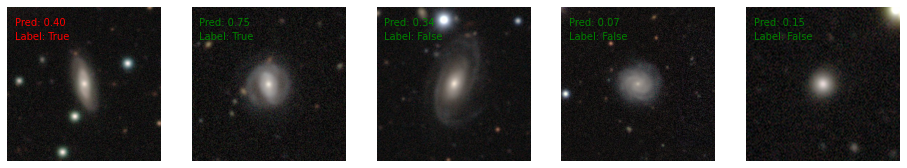

In [ ]:
random_predictions = predictions.sample(5)
print(random_predictions['id_str'])
show_rings(random_predictions)

Pretty good given only a couple of hundred examples for each class.


In [ ]:
train_catalog[label_col].value_counts()